# It's Raining Cats and Dogs!
   
##  Lab Assignment Eight: The Storm Continues
   
### Justin Ledford, Luke Wood, Traian Pop

## Business Understanding

### Overview
   
The data set we are analyzing has over 25000 evenly distributed pictures of dogs and cats. We found it on https://www.kaggle.com/c/dogs-vs-cats and decided it would be a good set to practice processing and analyzing image data due to the clear classification metric of dogs|cats and the large number of high quality photos.
 
### Purpose 
   
This data was originally collected for the purpose of a competition hosted by Kaggle to see who could create the most accurate algorithm that could distinguish between pictures of dogs and cats. Petfined.com are the original owners of the data, and they donated over 3 million pictures of sheltered animals that have been hand classified by them. Because of this, we are highly confident in the data, as the vast majority of humans can successfully identify between a dog and a cat. 
   
The competition itself is long over, but the page still remains for people to play and experiment with the data. This data is important due to potential it holds to help develop and train algorithms that could be used to evolve image recognition software. We can progressively check how useful the data we get from the set is by comparing it against our own classification and seeing if our own conclusions (i.e. if an image classifies a cat or not) match with the information we collect from it. 

### Predictions
   
We are not expecting perfect results as cats and dogs can look fairly similar at times, and the black and white color format of the pictures already limits easily differential characteristics between the two animals, such as fur color. However, we do believe that due to the large number and quality of the pictures, we can definitely expect to get a large amount of successful results when processing and analyzing the data.

### Applications
This dataset could be used to train an image classifier that could be used by hotels or apartment that only allow one type of pet.  For example, Luke's apartment complex only allows cats to stay in the homes so the complex could theoretically place cameras in the hallway and test to see which type of pets are being brought in.  This would allow them to more efficiently enforce the no dogs rule which is frequently broken.  

Another application is it could also be used for cataloging by a pet shelter to allow owners to search for cats or dogs similar to one they are looking for.

A third application would be to track the history of animals by taking pictures of them at each shelter and documenting information about the animal at each stage.

## Data Preparation (40 Points Total)

In this section, we pre-process the data in order to be usable by our techniques. The first method represents how we take all the images in a given folder (after they have been modified by our own scripts) and append them together to be analyzed later.
   
In pre-processing the data, we used three separate scripts:
   
<B>1) aspect</B>: Script developed by Fred Weinhaus (http://www.fmwconcepts.com/imagemagick/aspect/index.php) in order to resize an image to a specific size using imagmagick (https://www.imagemagick.org/) allowing either cropping or padding to deal with the aspect ratio change. (Not shown due to length)
   
<B>2) process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Uses padding to fill space leftover. Leaves all original content there, but adds noise to the edges to fill blanks.
   
<B>3) crop_process.sh</B>: Script that shrinks images to 150 x 150 while simultaneously using aspect to ensure accuracy. Instead of padding, it simply crops the image in respective to the middle of the original image. Loses quality and detail but no additional noise is added.
   
Afterward we preprocess the images with aspect and one of the following scripts, we append them all together in one dataframe.

### Importing the Data

In [11]:
import numpy as np
from PIL import Image
import pandas as pd
import os
import glob
import plotly
import matplotlib.pyplot as plt
%matplotlib inline 

#ignore warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

w,h = 50,50

def wildcard_to_df(fpath, greyscale=True):
    X = []
    y = []
    
    for img_file in glob.iglob(fpath):
        # Read in img as greyscale
        with Image.open(img_file).convert("L") as img:

            # Keep y for each image in separate array
            if 'cat' in img_file:
                y.append(0)
            else:
                y.append(1)

            # Concatenate RGB into one row and collect
            X.append(np.concatenate(np.array(img)))

    X = np.array(X)
    y = np.array(y)

    #convert to DF
    return pd.DataFrame(data=X, index=y), X, y

In [49]:
#convert to dataframe
df, X, y = wildcard_to_df('data/data/small/*.jpg')

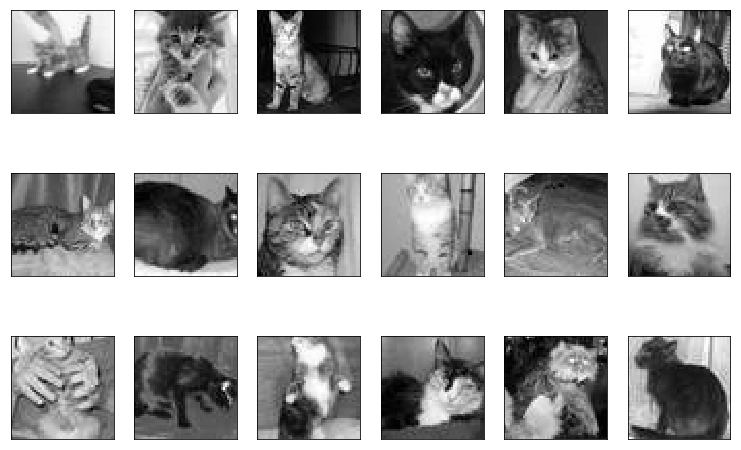

In [3]:
# a helper plotting function (modified code from Professor Eric Larson's repository)
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())

w,h = (50,50)
plot_gallery(X, h, w) # defaults to showing a 3 by 6 subset of the faces
# Visualize some images
plt.show()

Sample of random images taken from our dataset.

### Metrics of Evaluation

For our data set, we decided that just accuracy would be the best way to measure success due to the nature of the dataset. We are not interested in false positives or negatives, just simply at the classification success of seeing if it is a dog or a cat due to the purpose of our application.

### Splitting the Data

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [50]:
from sklearn.model_selection import train_test_split

NUM_CLASSES = 2
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train.shape

(1600, 2500)

We used just a simple shuffle split for our data due to the large dataset. In addition, our dataset was provided with a separate test directory with 500 images in order to valdiate our data, so the need for an optimal split was not as necessary.

## Modeling 

### Creating the Network

In this section, we start creating both our network and the MLP that we will use as a relative measure of performance.

In [36]:
%%time
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 32.5 s, sys: 6.56 s, total: 39.1 s
Wall time: 17.5 s


In [38]:
yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
cm = mt.confusion_matrix(y_test,yhat_mlp)
print(cm)
print(acc_mlp)

[[118  74]
 [ 83 125]]
0.6075


The MLP gets 60% accuracy which is pretty decent considering the complexity of the problem.

In [7]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,50,50), input_shape=(1,2500)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,150,150)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 1min 32s, sys: 17.4 s, total: 1min 49s
Wall time: 37.2 s


In [8]:
import sklearn.metrics as mt

yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
cm = mt.confusion_matrix(y_test,yhat_cnn)
print(cm)

[[113  83]
 [ 88 116]]


In [9]:
acc_cnn

0.57250000000000001

Our initial performance of 57% is not very ideal, so it might be more beneficial to change our architecture a bit.  It is important to note that our initial CNN architecture performed worse than a standard MLP which is pretty bad seeing as Convolutional Neural Networks are designed specifically to analyze images.

In [51]:
#architecture #2
# make a CNN with conv layer and max pooling
cnn2 = Sequential()
cnn2.add(Reshape((1,50,50), input_shape=(1,2500)))
cnn2.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,50,50)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

cnn2.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,25,25)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

In [52]:
import sklearn.metrics as mt

yhat_cnn2 = np.argmax(cnn2.predict(np.expand_dims(X_test, axis=1)), axis=1)
acc_cnn2 = mt.accuracy_score(y_test,yhat_cnn2)
cm2 = mt.confusion_matrix(y_test,yhat_cnn2)
print(cm2)
print(acc_cnn2)

[[ 93 100]
 [ 63 144]]
0.5925


Our performance improvement from changing the architecture and adding an extra convolution brought it up to 59.25% accuracy.  This is still worse than the MLP but is better than our last architecture.  We decided that possibly by using more data we could improve our CNNs performance.

### Data Addition and Generation

First, we load an additional 22,000 images into the dataset. 

In [12]:
import copy
df, X, y = wildcard_to_df('data/data/large/*.jpg')

NUM_CLASSES = 2
X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

X_train_mlp = copy.deepcopy(X_train)
X_test_mlp = copy.deepcopy(X_test)

X_train = np.expand_dims(X_train.reshape((-1,w,h)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,w,h)), axis=3)

X_train.shape


(20000, 50, 50, 1)

In [13]:
%%time

mlp = Sequential()
mlp.add( Dense(input_dim=X_train_mlp.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train_mlp, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 6min 30s, sys: 1min 33s, total: 8min 4s
Wall time: 3min 33s


In [14]:
import sklearn.metrics as mt

yhat_mlp = np.argmax(mlp.predict(X_test_mlp), axis=1)
acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
cm = mt.confusion_matrix(y_test,yhat_mlp)
print(cm)
print(acc_mlp)

[[1904  616]
 [1511  969]]
0.5746


We created an MLP with three layers and ended up getting 57.46% accuracy.  This is pretty mediocre still but is not that far off from what we got before.

In [32]:
# Generate more traning data by transforming training data

from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

Below is the CNN we trained on an AWS GPU instance with all the new data. It took about 20 minutes to train and got to approximately 81% on validation accuracy.

```python
from keras.regularizers import l2 
l2_lambda = 0.0001

# make a CNN with conv layer and max pooling
cnn = Sequential()

cnn.add(Conv2D(filters=32, input_shape=(w, h, 1),
                kernel_size=3, kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, data_format="channels_first"))

cnn.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_uniform',
                kernel_regularizer=l2(l2_lambda), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size=2, data_format="channels_first"))


# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
#cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
#        batch_size=256, epochs=50, 
#        shuffle=False, verbose=0, callbacks=[TQDMNotebookCallback()])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=50, verbose=0, callbacks=[TQDMNotebookCallback()],
                   validation_data=(X_test,y_test_ohe)
                  )
```

In [15]:
import h5py
import sklearn.metrics as mt
from keras.models import load_model
import tensorflow as tf
sess = tf.InteractiveSession()
with sess.as_default():
    cnn = load_model('cnn_81.h5')

We saved our CNN to a file called cnn_81.h5, named after the accuracy it achieved on the validation set.

In [16]:
with sess.as_default():
    yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
    acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
    cm = mt.confusion_matrix(y_test,yhat_cnn)
    print(cm)
    print(acc_cnn)

[[2048  472]
 [ 315 2165]]
0.8426


As we can see, CNN_81 gets slightly above 81% accuracy due to it having already been exposed to some of the data here.

### [20 points] Investigate at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the results of the CNNs. 

In [ ]:
%%time

# Compare different archs
df, X, y = wildcard_to_df('data/data/large/*.jpg')

X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255

n_splits = 5 

cnn1_scores = []
cnn2_scores = []

# Stratified shuffle split where training set is balanced, test set unbalanced
for i in range(0, n_splits):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    X_train_mlp = copy.deepcopy(X_train)
    X_test_mlp = copy.deepcopy(X_test)

    X_train = np.expand_dims(X_train.reshape((-1,w,h)), axis=3)
    X_test = np.expand_dims(X_test.reshape((-1,w,h)), axis=3)

    y_test = df_test_sample['income']

    yhat_dnn1 = list(dnn1.predict(input_fn=output_wrapper))
    print('DNN1')
    print(confusion_matrix(y_test,yhat_dnn1),
          recall_score(y_test,yhat_dnn1))
    
    
    dnn2.fit(input_fn=input_wrapper, steps=500)
    yhat_dnn2 = list(dnn2.predict(input_fn=output_wrapper))
    print('DNN2')
    print(confusion_matrix(y_test,yhat_dnn2),
          recall_score(y_test,yhat_dnn2))
    
    
    dnn1_scores.append(recall_score(y_test,yhat_dnn1))
    dnn2_scores.append(recall_score(y_test,yhat_dnn2))

We train two different deep network architectures and append the scores to a list to visualize later.

### [10 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. 

In [45]:
%%time

from numpy import interp
from sklearn.metrics import roc_curve, auc
df, X, y = wildcard_to_df('data/data/large/*.jpg')

X = X.astype(np.float32)
y = y.astype(np.int32)
X = X/255

mlp_roc_auc = []
cnn_roc_auc = []

mean_tpr_mlp = 0.0
mean_fpr_mlp = np.linspace(0, 1, 100)
mean_tpr_cnn = 0.0
mean_fpr_cnn = np.linspace(0, 1, 100)

n_splits = 5

for i in range(0, n_splits):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    X_train_mlp = copy.deepcopy(X_train)
    X_test_mlp = copy.deepcopy(X_test)
    
    X_train = np.expand_dims(X_train.reshape((-1,w,h)), axis=3)
    X_test = np.expand_dims(X_test.reshape((-1,w,h)), axis=3)

    yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
    yhat_mlp = np.argmax(mlp.predict(X_test_mlp), axis=1)
            
    print('CNN')
    print(mt.confusion_matrix(y_test,yhat_cnn),
         mt.accuracy_score(y_test,yhat_cnn))
    
    print('MLP')
    print(mt.confusion_matrix(y_test,yhat_mlp),
          mt.accuracy_score(y_test,yhat_mlp))
    
    probs_cnn = list(cnn.predict_proba(X_test))
    probs_cnn = np.array(probs_cnn)[:,1]
    fpr_cnn, tpr_cnn, _ = roc_curve(y_test, probs_cnn)
    cnn_roc_auc.append((fpr_cnn, tpr_cnn, auc(fpr_cnn, tpr_cnn)))
    mean_tpr_cnn += interp(mean_fpr_cnn, fpr_cnn, tpr_cnn)
    mean_tpr_cnn[0] = 0.0   

    probs_mlp = mlp.predict_proba(X_test_mlp)
    probs_mlp = np.array(probs_mlp)[:,1]
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp)
    mlp_roc_auc.append((fpr_mlp, tpr_mlp, auc(fpr_mlp, tpr_mlp)))
    mean_tpr_mlp  += interp(mean_fpr_mlp, fpr_mlp, tpr_mlp)
    mean_tpr_mlp [0] = 0.0



CNN
[[1987  514]
 [ 332 2167]] 0.8308
MLP
[[1445 1056]
 [ 988 1511]] 0.5912
3456/5000 [===================>..........] - ETA: 0sCNN
[[2051  454]
 [ 337 2158]] 0.8418
MLP
[[1438 1067]
 [ 966 1529]] 0.5934
4928/5000 [============================>.] - ETA: 0sCNN
[[1983  530]
 [ 315 2172]] 0.831
MLP
[[1415 1098]
 [ 992 1495]] 0.582
3584/5000 [====================>.........] - ETA: 0sCNN
[[1974  527]
 [ 352 2147]] 0.8242
MLP
[[1439 1062]
 [1005 1494]] 0.5866
4768/5000 [===========================>..] - ETA: 0sCNN
[[2023  492]
 [ 309 2176]] 0.8398
MLP
[[1395 1120]
 [ 946 1539]] 0.5868
4928/5000 [============================>.] - ETA: 0sCPU times: user 11min 20s, sys: 46 s, total: 12min 6s
Wall time: 2min 19s


As we can see, our CNN performs far better than the MLP getting up to 84% accuracy which is very impressive.  

In [46]:
mean_tpr_mlp /= n_splits
mean_tpr_mlp[-1] = 1.0
mean_auc_mlp = auc(mean_fpr_mlp, mean_tpr_mlp)

mean_tpr_cnn /= n_splits
mean_tpr_cnn[-1] = 1.0
mean_auc_cnn = auc(mean_fpr_cnn, mean_tpr_cnn)

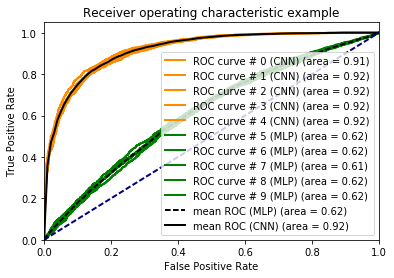

In [47]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
i = 0
for fpr, tpr, auc_ in cnn_roc_auc:
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve # %d (CNN) (area = %0.2f)' % (i, auc_))
        i += 1
for fpr, tpr, auc_ in mlp_roc_auc:
        plt.plot(fpr, tpr, color='green',
             lw=lw, label='ROC curve # %d (MLP) (area = %0.2f)' % (i, auc_))
        i += 1        
        
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'k--', label='mean ROC (MLP) (area = %0.2f)' % mean_auc_mlp, lw=2)
plt.plot(mean_fpr_cnn, mean_tpr_cnn, 'k-', label='mean ROC (CNN) (area = %0.2f)' % mean_auc_cnn, lw=2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Exceptional Work (10 points total)

We visualized the convolution kernels learned by the network.  To get to the kernel, we did a little bit of digging through the internels of the keras sequential object.  

In [3]:
def show_attributes(obj):
    print('\n'.join("%s: %s" % item for item in vars(obj).items()))

This function displays all of the attributes of an object.

In [1]:
import h5py
import sklearn.metrics as mt
from keras.models import load_model
import tensorflow as tf
sess = tf.InteractiveSession()
with sess.as_default():
    cnn = load_model('cnn_81.h5')
cnn

Using TensorFlow backend.


We have to load the cnn using an interactive session in order to preserve the state of the variables learned in the network.

In [4]:
show_attributes(cnn)

output_names: ['dense_2']
_output_mask_cache: {'4834445912_4551135832': None}
loss_weights: None
input_layers_node_indices: [0]
metrics_names: ['loss', 'acc']
output_layers_tensor_indices: [0]
outbound_nodes: []
_output_shape_cache: {}
output_layers: [<keras.layers.core.Dense object at 0x120381c50>]
_trainable: True
_feed_inputs: [<tf.Tensor 'conv2d_1_input:0' shape=(?, 50, 50, 1) dtype=float32>]
_initial_weights: None
sample_weight_mode: None
container_nodes: {'dropout_2_ib-0', 'dropout_1_ib-0', 'dense_1_ib-0', 'conv2d_2_ib-0', 'conv2d_1_input_ib-0', 'conv2d_1_ib-0', 'max_pooling2d_2_ib-0', 'dense_2_ib-0', 'max_pooling2d_1_ib-0', 'flatten_1_ib-0'}
input_layers_tensor_indices: [0]
_output_tensor_cache: {}
model: <keras.engine.training.Model object at 0x11112f6a0>
metrics: ['accuracy']
outputs: [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 2) dtype=float32>]
optimizer: <keras.optimizers.Adam object at 0x1203f2b70>
output_layers_node_indices: [0]
inputs: [<tf.Tensor 'conv2d_1_input:0' shape=

We notice that we can access layers through the layers attribute.  I take the first layer as it is a convolutional layer so we will be able to grab the filters.

In [5]:
conv_first = cnn.layers[0]

In [6]:
show_attributes(conv_first)

losses: [<tf.Tensor 'conv2d_1/add:0' shape=() dtype=float32>]
trainable: True
bias: Tensor("conv2d_1/bias/read:0", shape=(32,), dtype=float32)
bias_constraint: None
kernel_constraint: None
use_bias: True
activation: <function relu at 0x11fad9730>
kernel_initializer: <keras.initializers.VarianceScaling object at 0x12027c358>
dtype: float32
_non_trainable_weights: []
dilation_rate: (1, 1)
kernel: Tensor("conv2d_1/kernel/read:0", shape=(3, 3, 1, 32), dtype=float32)
data_format: channels_last
_trainable_weights: [<tensorflow.python.ops.variables.Variable object at 0x12027c7b8>, <tensorflow.python.ops.variables.Variable object at 0x12028ce10>]
input_spec: <keras.engine.topology.InputSpec object at 0x12021f940>
_per_input_losses: {None: [<tf.Tensor 'conv2d_1/add:0' shape=() dtype=float32>]}
name: conv2d_1
padding: same
_initial_weights: None
bias_regularizer: None
kernel_size: (3, 3)
_constraints: {}
supports_masking: False
rank: 2
batch_input_shape: (None, 50, 50, 1)
activity_regularizer: N

In [7]:
trainable_weights = conv_first._trainable_weights
trainable_weights

I notice that there are trainable weights which are of type tf.Variable, but these are not the correct dimensions for the convolutional filters so we keep searching.

In [8]:
import numpy as np
import tensorflow as tf
weights = cnn.layers[0].kernel.eval()
weights = np.array(weights)

The kernel attribute is the correct dimension and can be accesses due to the interactive session we established earlier.

In [9]:
weights.shape

(3, 3, 1, 32)

As we can see, we have 32 3x3 filters.

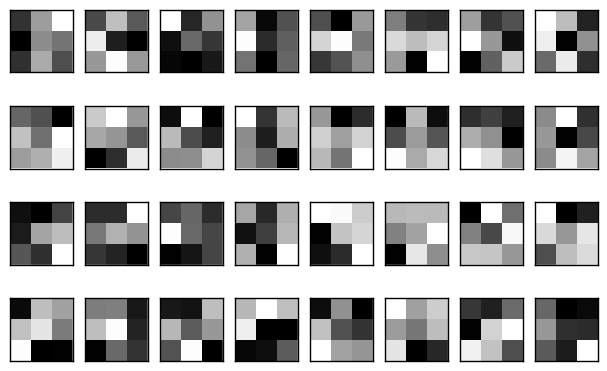

In [12]:
%matplotlib inline
weights = weights.squeeze()
# get into friendly format
plt.figure()
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for z,i in zip(np.transpose(weights),range(32)):
    plt.subplot(4, 8, i + 1)
    plt.imshow(z.reshape((3,3)), cmap=plt.cm.gray,interpolation='none')
    plt.xticks(())
    plt.yticks(())
plt.show()

All of these filters show up pretty differently which is fascinating.  These are the 32 filters that our convolutional neural network trained on the AWS GPU cluster learned.